
# Lasso model selection via information criteria

This example reproduces the example of Fig. 2 of [ZHT2007]_. A
:class:`~sklearn.linear_model.LassoLarsIC` estimator is fit on a
diabetes dataset and the AIC and the BIC criteria are used to select
the best model.

<div class="alert alert-info"><h4>Note</h4><p>It is important to note that the optimization to find `alpha` with
    :class:`~sklearn.linear_model.LassoLarsIC` relies on the AIC or BIC
    criteria that are computed in-sample, thus on the training set directly.
    This approach differs from the cross-validation procedure. For a comparison
    of the two approaches, you can refer to the following example:
    `sphx_glr_auto_examples_linear_model_plot_lasso_model_selection.py`.</p></div>

.. rubric:: References

.. [ZHT2007] :arxiv:`Zou, Hui, Trevor Hastie, and Robert Tibshirani.
    "On the degrees of freedom of the lasso."
    The Annals of Statistics 35.5 (2007): 2173-2192.
    <0712.0881>`


In [1]:
# Author: Alexandre Gramfort
#         Guillaume Lemaitre
# License: BSD 3 clause

We will use the diabetes dataset.



In [2]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
n_samples = X.shape[0]
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


Scikit-learn provides an estimator called
:class:`~sklearn.linear_model.LassoLarsIC` that uses either Akaike's
information criterion (AIC) or the Bayesian information criterion (BIC) to
select the best model. Before fitting
this model, we will scale the dataset.

In the following, we are going to fit two models to compare the values
reported by AIC and BIC.



In [26]:
import numpy as np
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)

### Least Angle Regression (LARS)

#### Concept

Least Angle Regression (LARS) is a regression algorithm particularly well-suited for high-dimensional data, where the number of features exceeds or is comparable to the number of observations. LARS is a model selection method for linear regression that builds the model incrementally. It is closely related to forward stepwise regression and the Lasso method.

LARS has a unique property: it is computationally efficient and can be used to produce the full piecewise linear solution path for various regression problems, including Lasso regression.

#### Mathematical Background

LARS constructs the solution path by iteratively adding predictors to the model. The key steps in the LARS algorithm are:

1. **Initialization**:
   - Start with all coefficients $\ \beta_j = 0$.
   - Set the residuals to $\  \vec{r} = \vec{y} - \hat{\vec{y}} $, where $\  \hat{\vec{y}} $ is the current predicted value.

2. **Identify the Most Correlated Predictor**:
   - Compute the correlation of each predictor $\  \vec{x}_j $ with the current residuals $\  \vec{r} $.
   - Select the predictor $\  \vec{x}_j $ with the highest absolute correlation.

3. **Move Coefficients in the Direction of the Selected Predictor**:
   - Move the coefficient $\  \beta_j $ of the selected predictor in the direction that reduces the residual sum of squares.
   - The step size is chosen such that the correlation of the selected predictor with the residuals decreases at the same rate as the other predictors that are equally correlated with the residuals.

4. **Equiangular Update**:
   - Move in the direction of the selected predictor until another predictor has the same correlation with the current residuals.
   - At each step, update the coefficients of the selected predictors equiangularly, meaning that the angles between the predictor vectors and the residual vector are equal.

5. **Repeat Steps 2-4**:
   - Continue this process until all predictors are in the model or the desired number of steps is reached.

#### LARS and Lasso

LARS can be modified to solve the Lasso problem by adding an extra step to truncate the coefficients at zero when their path crosses zero. This ensures that some coefficients are exactly zero, providing a sparse solution.

#### LassoLars in Sklearn

`LassoLars` is an implementation of the Lasso regression using the LARS algorithm in scikit-learn. It leverages the efficiency of LARS to solve the Lasso problem.

#### Key Arguments

- **alpha**: Regularization parameter. The default is 1.0. Smaller values lead to less regularization.
- **fit_intercept**: Whether to calculate the intercept for this model. If set to False, no intercept will be used.
- **verbose**: Controls the verbosity of the output.
- **normalize**: Whether to normalize the predictors before regression.
- **precompute**: Whether to use a precomputed Gram matrix to speed up computations.
- **max_iter**: Maximum number of iterations.
- **eps**: The machine-precision regularization in the computation.
- **n_nonzero_coefs**: Target number of non-zero coefficients. If not None, overrides the alpha parameter.



To be in line with the definition in [ZHT2007]_, we need to rescale the
AIC and the BIC. Indeed, Zou et al. are ignoring some constant terms
compared to the original definition of AIC derived from the maximum
log-likelihood of a linear model. You can refer to
`mathematical detail section for the User Guide <lasso_lars_ic>`.



In [27]:
def zou_et_al_criterion_rescaling(criterion, n_samples, noise_variance):
    """Rescale the information criterion to follow the definition of Zou et al."""
    return criterion - n_samples * np.log(2 * np.pi * noise_variance) - n_samples

In [22]:
import numpy as np

aic_criterion = zou_et_al_criterion_rescaling(
    lasso_lars_ic[-1].criterion_,
    n_samples,
    lasso_lars_ic[-1].noise_variance_,
)

index_alpha_path_aic = np.flatnonzero(
    lasso_lars_ic[-1].alphas_ == lasso_lars_ic[-1].alpha_
)[0]

In [30]:
lasso_lars_ic[-1].alpha_

0.9504071158262754

In [32]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)

bic_criterion = zou_et_al_criterion_rescaling(
    lasso_lars_ic[-1].criterion_,
    n_samples,
    lasso_lars_ic[-1].noise_variance_,
)

index_alpha_path_bic = np.flatnonzero(
    lasso_lars_ic[-1].alphas_ == lasso_lars_ic[-1].alpha_
)[0]

Now that we collected the AIC and BIC, we can as well check that the minima
of both criteria happen at the same alpha. Then, we can simplify the
following plot.



In [37]:
index_alpha_path_aic == index_alpha_path_bic

lasso_lars_ic[-1].alphas_[index_alpha_path_aic] == lasso_lars_ic[-1].alpha_

True

Finally, we can plot the AIC and BIC criterion and the subsequent selected
regularization parameter.



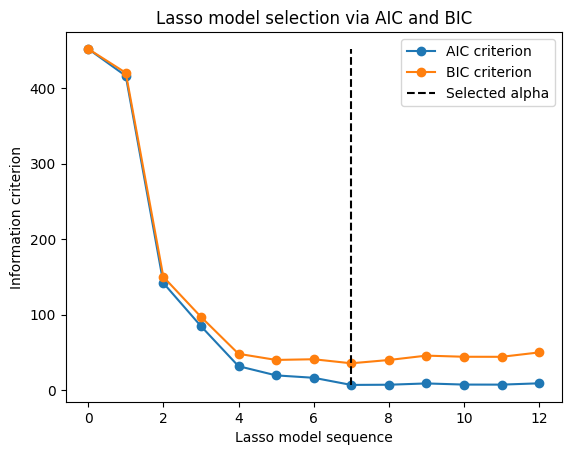

In [34]:
import matplotlib.pyplot as plt

plt.plot(aic_criterion, color="tab:blue", marker="o", label="AIC criterion")
plt.plot(bic_criterion, color="tab:orange", marker="o", label="BIC criterion")
plt.vlines(
    index_alpha_path_bic,
    aic_criterion.min(),
    aic_criterion.max(),
    color="black",
    linestyle="--",
    label="Selected alpha",
)
plt.legend()
plt.ylabel("Information criterion")
plt.xlabel("Lasso model sequence")
_ = plt.title("Lasso model selection via AIC and BIC")